In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

import shapely
import shapely.geometry
from PIL import ImageFont, ImageDraw, Image

dev


In [2]:
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)

In [3]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [4]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [5]:
foods = read_sql('foods')
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [6]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [7]:
food_clips = series2tensor(foods['clip'])

/tmp/ipykernel_111454/2423156918.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [8]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [9]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [ ]:
url = 'https://image.shutterstock.com/z/stock-photo-top-view-of-a-restaurant-table-served-with-a-multi-course-set-lunch-and-drink-complex-lunch-1846351336.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [ ]:
thershold = 0.0003
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [ ]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [ ]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://glovo.away.guru/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','category','energy','protein','carb','fat','score']]

In [ ]:
df = clip_df.join(df)
df = df[df['score']>0.24]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [ ]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [ ]:
classes =  arrays[:,0,:,:].max(0)

In [ ]:
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)

In [ ]:
df_count_classes['%'] = (df_count_classes['box_area_rank']/df_count_classes['box_area_rank'].sum()).round(2)
r = df_count_classes[['%']].join(df.drop_duplicates('description').set_index('description')[['category','energy','protein','carb','fat']])

In [ ]:
r

,%,category,energy,protein,carb,fat
description,,,,,,
"Chicken or turkey, noodles, and vegetables including carrots, broccoli, and/or dark-green leafy; cheese sauce",0.68,Poultry mixed dishes,145.0,8.90,14.16,5.97
"Egg omelet or scrambled egg, with cheese, made with cooking spray",0.06,Eggs and omelets,176.0,13.48,1.35,12.58
"Bread, Italian, Grecian, Armenian",0.05,Yeast breads,259.0,9.49,48.11,2.73
"Tuna salad, made with any type of fat free dressing",0.03,Seafood mixed dishes,74.0,9.64,6.18,1.15
"Garlic bread, from fast food / restaurant",0.02,Yeast breads,349.0,8.34,41.64,16.58
"Bread, reduced calorie and/or high fiber, white or NFS, with fruit and/or nuts",0.02,Yeast breads,222.0,7.83,49.95,2.14
"Chicken breast, baked, broiled, or roasted, skin eaten, from raw",0.02,"Chicken, whole pieces",192.0,26.25,0.00,8.80
"Egg omelet or scrambled egg, with dark-green vegetables, NS as to fat",0.02,Eggs and omelets,165.0,10.65,1.26,12.82
"Chicken breast, grilled without sauce, skin eaten",0.02,"Chicken, whole pieces",206.0,25.72,0.00,10.62


In [ ]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

171.07388225998605

In [ ]:
df_count_classes

,box_area_rank
description,
"Chicken or turkey, noodles, and vegetables including carrots, broccoli, and/or dark-green leafy; cheese sauce",811167
"Egg omelet or scrambled egg, with cheese, made with cooking spray",67499
"Bread, Italian, Grecian, Armenian",56881
"Tuna salad, made with any type of fat free dressing",31829
"Garlic bread, from fast food / restaurant",29684
"Bread, reduced calorie and/or high fiber, white or NFS, with fruit and/or nuts",25262
"Chicken breast, baked, broiled, or roasted, skin eaten, from raw",23389
"Egg omelet or scrambled egg, with dark-green vegetables, NS as to fat",20079
"Chicken breast, grilled without sauce, skin eaten",19762


In [ ]:
image

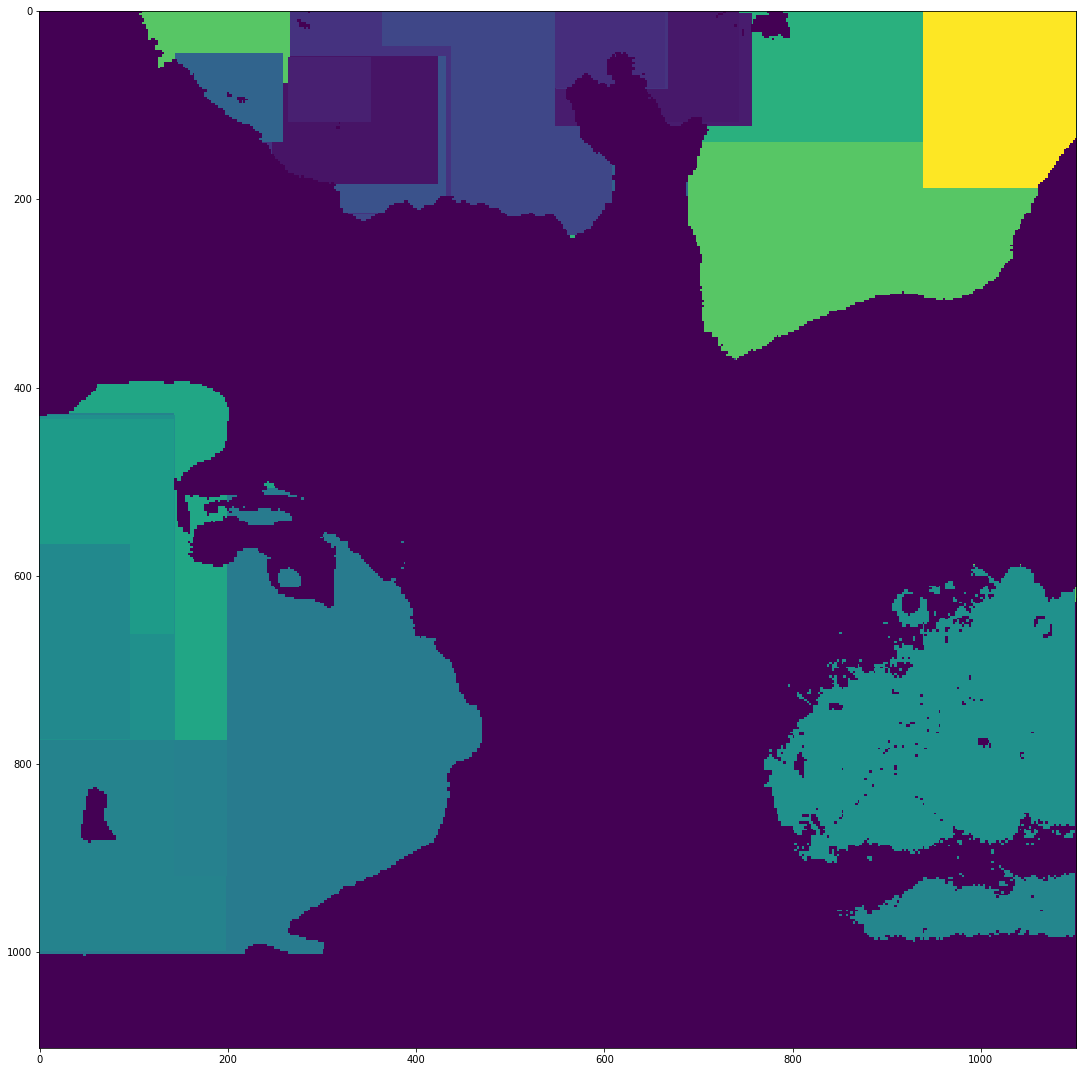

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=1)